In [38]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.stats import zscore

In [40]:
# Load the Dataset
data = pd.read_excel("EastWestAirlines.xlsx", sheet_name=1)

In [41]:
# Quick look at dataset
print("Shape of dataset:", data.shape)
print(data.head())


Shape of dataset: (3999, 12)
   ID#  Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  Bonus_miles  \
0    1    28143           0          1          1          1          174   
1    2    19244           0          1          1          1          215   
2    3    41354           0          1          1          1         4123   
3    4    14776           0          1          1          1          500   
4    5    97752           0          4          1          1        43300   

   Bonus_trans  Flight_miles_12mo  Flight_trans_12  Days_since_enroll  Award?  
0            1                  0                0               7000       0  
1            2                  0                0               6968       0  
2            4                  0                0               7034       0  
3            1                  0                0               6952       0  
4           26               2077                4               6935       1  


Data Preprocessing

In [42]:
# Drop ID column if present (non-informative for clustering)
if 'ID#' in data.columns:
    data = data.drop(['ID#'], axis=1)

In [43]:
# Check for missing values
print("Missing values in dataset:\n", data.isnull().sum())

Missing values in dataset:
 Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award?               0
dtype: int64


In [44]:
# Handle missing values (if any, fill with mean)
data = data.fillna(data.mean())

In [45]:
# Remove outliers using Z-score method (|z| > 3)
z_scores = np.abs(zscore(data))
data = data[(z_scores < 3).all(axis=1)]

In [46]:
# Scale the data (important for KMeans & DBSCAN)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)


EDA

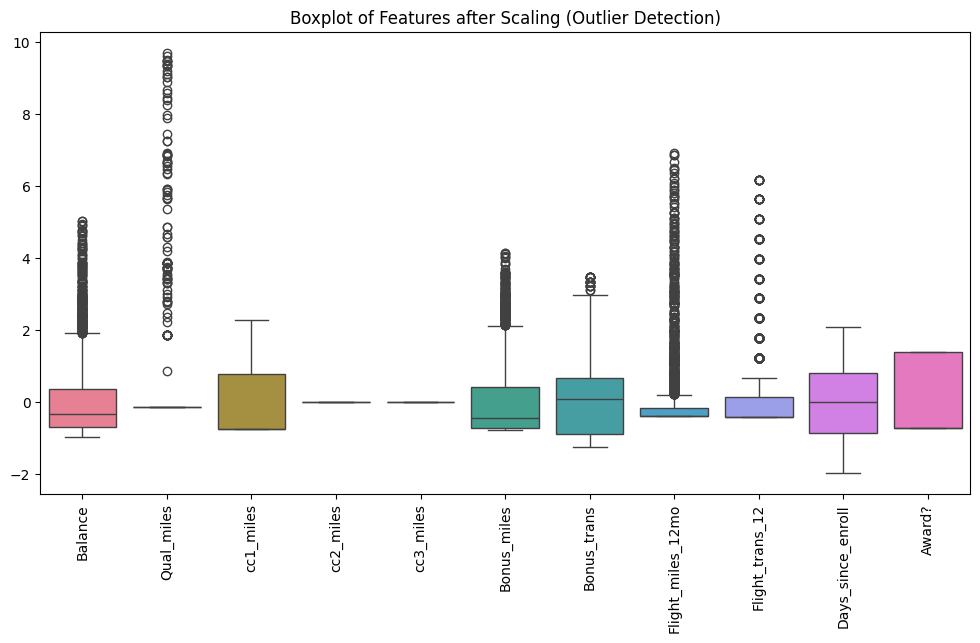

In [47]:
# Distribution of features
plt.figure(figsize=(12,6))
sns.boxplot(data=pd.DataFrame(scaled_data, columns=data.columns))
plt.title("Boxplot of Features after Scaling (Outlier Detection)")
plt.xticks(rotation=90)
plt.show()

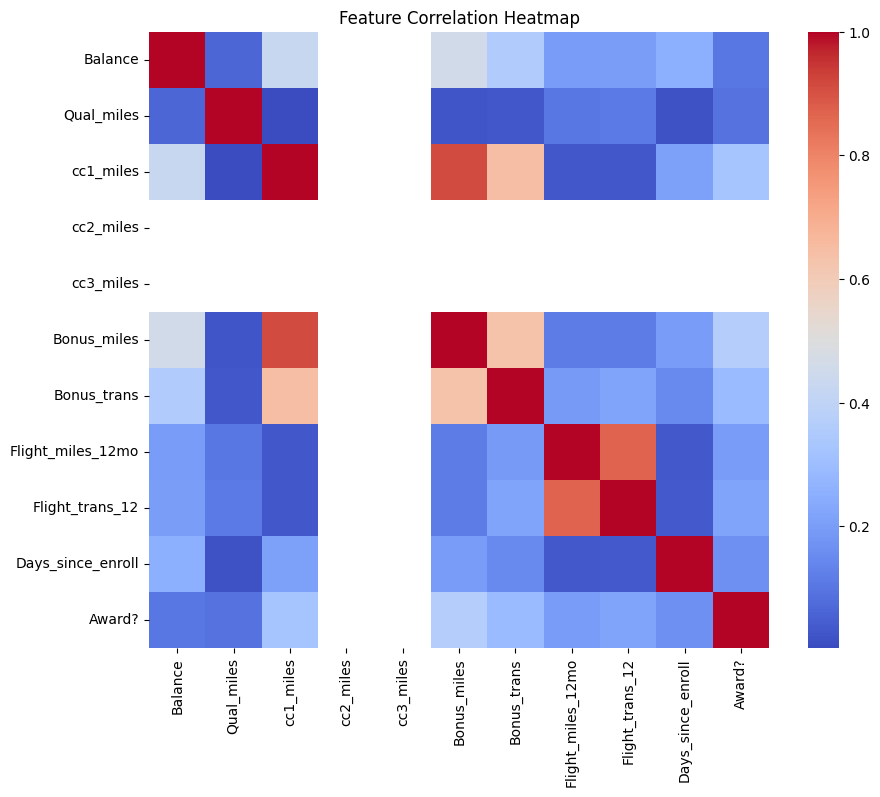

In [48]:
# Correlation Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(scaled_data, columns=data.columns).corr(), annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


K-Means Clustering

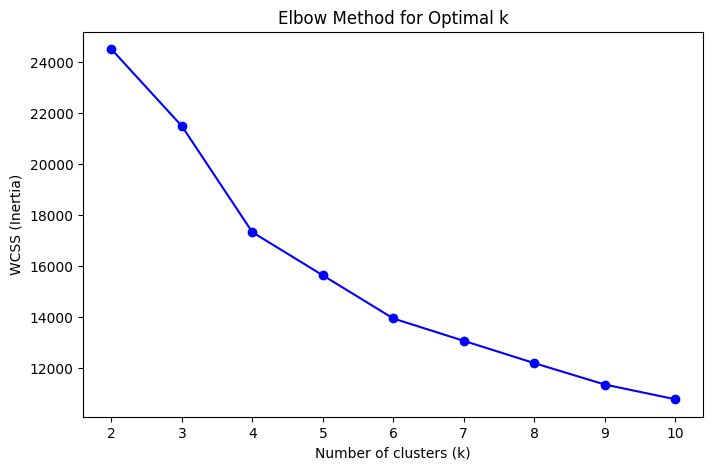

In [49]:
# Elbow method to find optimal k
wcss = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, wcss, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.show()

In [50]:
# From elbow choose k=3 or 4 (example, we’ll use 4)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)


In [51]:
# Silhouette score for KMeans
kmeans_silhouette = silhouette_score(scaled_data, kmeans_labels)
print("Silhouette Score for KMeans:", kmeans_silhouette)


Silhouette Score for KMeans: 0.3316635667716135


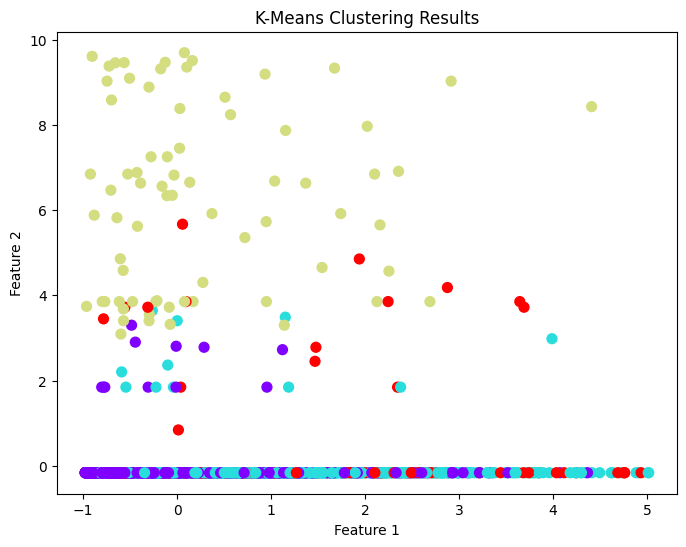

In [52]:
# Visualize KMeans clustering (using first 2 principal features)
plt.figure(figsize=(8,6))
plt.scatter(scaled_data[:,0], scaled_data[:,1], c=kmeans_labels, cmap='rainbow', s=50)
plt.title("K-Means Clustering Results")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

DBSCAN Clustering

In [53]:
dbscan = DBSCAN(eps=1.8, min_samples=10)  # Parameters can be tuned
dbscan_labels = dbscan.fit_predict(scaled_data)

In [55]:
 #Silhouette score for DBSCAN (only if more than 1 cluster found)
if len(set(dbscan_labels)) > 1 and -1 not in set(dbscan_labels):
    dbscan_silhouette = silhouette_score(scaled_data, dbscan_labels)
else:
    dbscan_silhouette = "Not defined (DBSCAN detected noise only or single cluster)"

print("Silhouette Score for DBSCAN:", dbscan_silhouette)

Silhouette Score for DBSCAN: Not defined (DBSCAN detected noise only or single cluster)


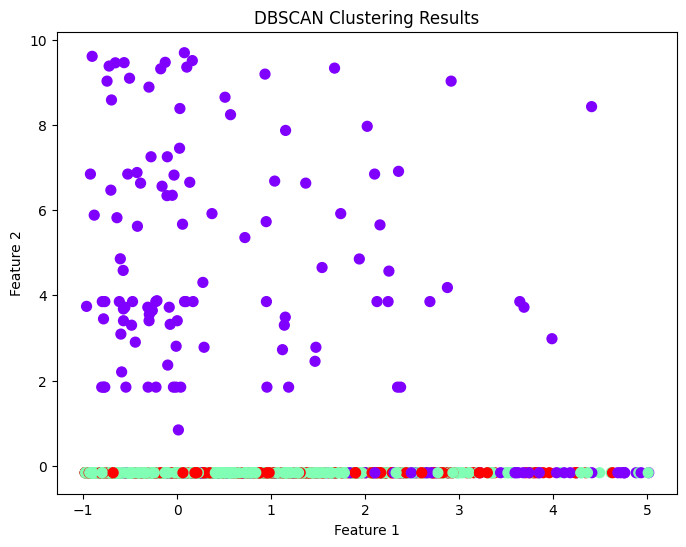

In [56]:
# Visualize DBSCAN clustering
plt.figure(figsize=(8,6))
plt.scatter(scaled_data[:,0], scaled_data[:,1], c=dbscan_labels, cmap='rainbow', s=50)
plt.title("DBSCAN Clustering Results")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()



 Cluster Analysis & Insights

In [57]:
data['KMeans_Cluster'] = kmeans_labels
data['DBSCAN_Cluster'] = dbscan_labels


In [59]:
# Mean values of each cluster (KMeans)
print("\nCluster-wise characteristics (KMeans):")
print(data.groupby('KMeans_Cluster').mean())


Cluster-wise characteristics (KMeans):
                     Balance   Qual_miles  cc1_miles  cc2_miles  cc3_miles  \
KMeans_Cluster                                                               
0               37033.132146     3.194002   1.139644        1.0        1.0   
1               94615.303030     6.099327   3.537879        1.0        1.0   
2               77728.083333  1616.847222   1.847222        1.0        1.0   
3               96005.461864    56.004237   2.042373        1.0        1.0   

                 Bonus_miles  Bonus_trans  Flight_miles_12mo  Flight_trans_12  \
KMeans_Cluster                                                                  
0                3544.908154     6.006560          93.823805         0.335052   
1               32600.534512    17.328283         143.514310         0.460438   
2               14244.125000    10.791667         468.708333         1.541667   
3               19432.966102    16.118644        2222.381356         6.258475   

    

In [60]:
# Count of each DBSCAN cluster
print("\nCluster distribution (DBSCAN):")
print(data['DBSCAN_Cluster'].value_counts())


Cluster distribution (DBSCAN):
DBSCAN_Cluster
 0    2302
 1    1094
-1     234
Name: count, dtype: int64


1. **Data Loading & Preprocessing**

Loaded dataset from Excel (EastWestAirlines.xlsx).

Removed non-informative ID column.

Checked and filled missing values (mean imputation).

Removed outliers using Z-score method (|z| > 3).

Scaled all features using StandardScaler (important for K-Means & DBSCAN).

2. **Exploratory Data Analysis (EDA)**

Used Boxplots to see feature distributions and outliers.

Used Correlation Heatmap to check relationships among variables.

3. **K-Means Clustering**

Used Elbow Method (WCSS vs K) to choose optimal clusters (~3–4).

Trained K-Means with chosen cluster size (example: 4 clusters).

Evaluated clustering with Silhouette Score.

Visualized results with scatter plot (first 2 features).

4. **DBSCAN Clustering**

Applied DBSCAN with tuned parameters (eps=1.8, min_samples=10).

Detected clusters + noise points (-1 = noise).

Checked Silhouette Score (if valid clusters exist).

Visualized clustering with scatter plot.

5. **Cluster Analysis & Insights**

Assigned cluster labels back to dataset for both K-Means & DBSCAN.

Summarized cluster-wise means (K-Means) → helps interpret group behavior.

Checked distribution of DBSCAN clusters (number of points per cluster/noise).

6. **Evaluation**

K-Means: Good for balanced, spherical clusters; provides interpretable group centers.

DBSCAN: Good at detecting irregular clusters & noise, but results depend heavily on parameters (eps, minPts).

Used Silhouette Score for internal evaluation.